In [30]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import yaml

def load_yaml_params(path):
    s = path.open('r').readlines()
    output = s[:7] + s[12:]
    output = '\n'.join(output)
    output = yaml.load(output)
    output['path'] = str(path)
    return output

def load_yaml(path):
    with path.open('r') as handle:
        return yaml.load(handle)
    
def calculate_speedup(duration):
    return 1 / (duration / duration.iloc[0])
    
    
def calculate_benchmark_stats(df):
    df = df.sort_values('type')
    df['speedup_train'] = calculate_speedup(df.total_duration_train)
    df['warmup_speedup_train'] = calculate_speedup(df.warmup_duration_train)
    df['post_duration_train'] = df.total_duration_train - df.warmup_duration_train
    df['post_speedup_train'] = calculate_speedup(df.post_duration_train)
    return df

plt.style.use('ggplot')

In [23]:
params = Path('/home/lhs18285/git/benchmarks/pearl-dev/').glob('**/*params.yml')
results = Path('/home/lhs18285/git/benchmarks/pearl-dev/').glob('**/*results.yml')

params = list(map(load_yaml_params, params))
results = list(map(load_yaml, results))

params_df = pd.DataFrame(params)

results_train_df = pd.DataFrame([r['train'] for r in results])
results_test_df = pd.DataFrame([r['test'] for r in results])
results_df = pd.merge(results_train_df, results_test_df, left_index=True, right_index=True, suffixes=['_train', '_test'])
results_df

bench_df = params_df.join(results_df)
bench_df['benchmark'] = bench_df['data_dir'].str.split('/').map(lambda x: x[-1])
bench_df['type'] = bench_df['path'].str.split('/').map(lambda x: x[-3])
bench_df

/home/lhs18285/miniconda3/envs/benchmarks/lib/python3.7/site-packages/ipykernel_launcher.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # Remove the CWD from sys.path while we load stuff.
/home/lhs18285/miniconda3/envs/benchmarks/lib/python3.7/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


,batch_size,cpu_only,data_dir,epochs,exec_mode,global_batch_size,learning_rate,num_replicas,seed,use_amp,...,warmup_duration_train,accuracy,avg_ips_test,full_avg_ips_test,loss,total_duration_test,warmup_avg_ips_test,warmup_duration_test,benchmark,type
0,4,False,data/slstr_cloud,2,train_and_predict,4,0.001,1,42,False,...,749.639632,0.830219,5.918384,5.978351,0.803187,131.182788,6.727934,18.656909,slstr_cloud,gpu
1,4,True,data/slstr_cloud,2,train_and_predict,4,0.001,1,42,False,...,4085.717403,0.801289,1.535941,1.520317,0.576120,241.137821,1.325017,32.272359,slstr_cloud,cpu


# SLSTR Benchmark

In [31]:
slstr_benchmark = bench_df.loc[bench_df['benchmark'] == 'slstr_cloud']
slstr_benchmark = calculate_benchmark_stats(slstr_benchmark)

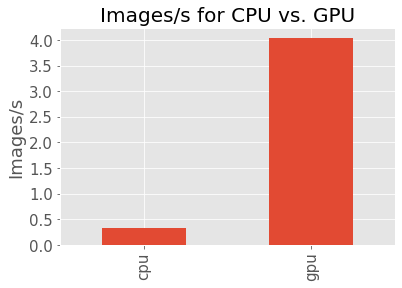

In [76]:
slstr_benchmark.plot(kind='bar', x='type', y='avg_ips_train', legend=False)
plt.xlabel('')
plt.ylabel('Images/s', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Images/s for CPU vs. GPU', fontsize=20)
plt.savefig('imgs-cpu-gpu.png', dpi=300, bbox_inches='tight')

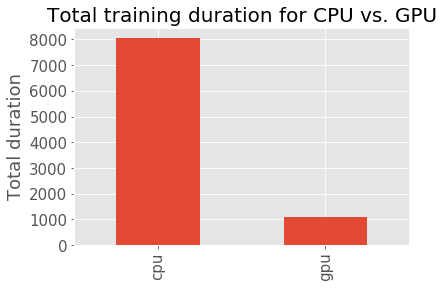

In [75]:
slstr_benchmark.plot(kind='bar', x='type', y=['total_duration_train'], legend=False)
plt.xlabel('')
plt.ylabel('Total duration', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total training duration for CPU vs. GPU', fontsize=20)
plt.savefig('duration-cpu-gpu.png', dpi=300, bbox_inches='tight')

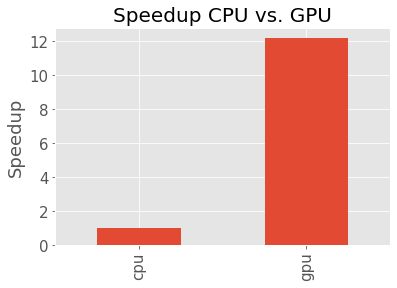

In [78]:
slstr_benchmark.plot(kind='bar', x='type', y=['post_speedup_train'], legend=False)
plt.xlabel('')
plt.ylabel('Speedup', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Speedup CPU vs. GPU', fontsize=20)
plt.savefig('speedup-cpu-gpu.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Speedup Factor vs. No. GPUs for PEARL (DGX-2)')

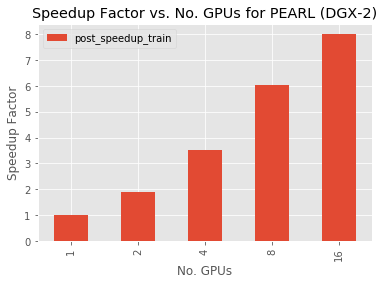

In [221]:
slstr_benchmark.plot(kind='bar', x='num_replicas', y=['post_speedup_train'])
plt.xlabel('No. GPUs')
plt.ylabel('Speedup Factor')
plt.title('Speedup Factor vs. No. GPUs for PEARL (DGX-2)')

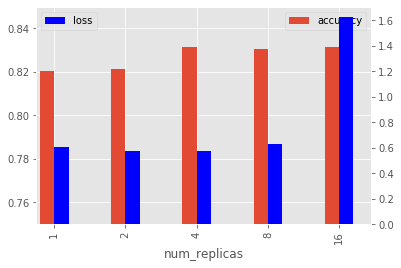

In [203]:
# ax = slstr_benchmark.plot(kind='bar', x='num_replicas', y=['accuracy', 'loss'], ylim=[.75, .9])

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width=0.2
slstr_benchmark.plot(kind='bar', x='num_replicas', y='accuracy', ax=ax, width=width, position=1, ylim=[.75, .85])
slstr_benchmark.plot(kind='bar', x='num_replicas', y='loss', color='blue', ax=ax2, width=width, position=0)
ax2.grid(None)

# EM Denoise Benchmark

In [173]:
em_denoise_benchmark = bench_df.loc[bench_df['benchmark'] == 'em_denoise']
em_denoise_benchmark = calculate_benchmark_stats(em_denoise_benchmark)

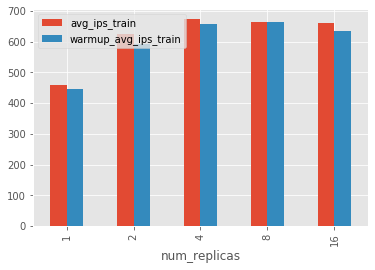

In [174]:
em_denoise_benchmark.plot(kind='bar', x='num_replicas', y=['avg_ips_train', 'warmup_avg_ips_train'])

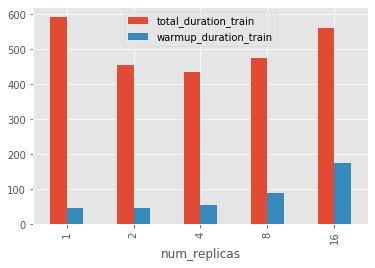

In [175]:
em_denoise_benchmark.plot(kind='bar', x='num_replicas', y=['total_duration_train', 'warmup_duration_train'])

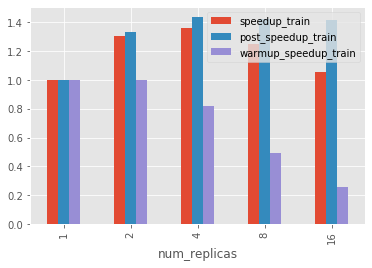

In [176]:
em_denoise_benchmark.plot(kind='bar', x='num_replicas', y=['speedup_train', 'post_speedup_train', 'warmup_speedup_train'])

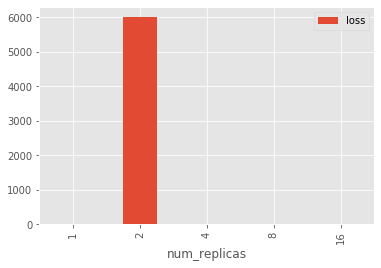

In [207]:
em_denoise_benchmark.plot(kind='bar', x='num_replicas', y='loss')

## DMS Classifier Benchmark

In [208]:
dms_classifier_benchmark = bench_df.loc[bench_df['benchmark'] == 'dms_classifier']
dms_classifier_benchmark = calculate_benchmark_stats(dms_classifier_benchmark)

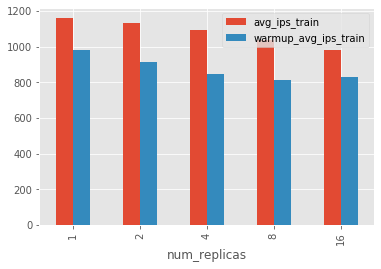

In [209]:
dms_classifier_benchmark.plot(kind='bar', x='num_replicas', y=['avg_ips_train', 'warmup_avg_ips_train'])

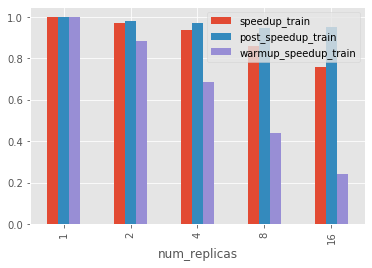

In [216]:
dms_classifier_benchmark.plot(kind='bar', x='num_replicas', y=['speedup_train', 'post_speedup_train', 'warmup_speedup_train'])

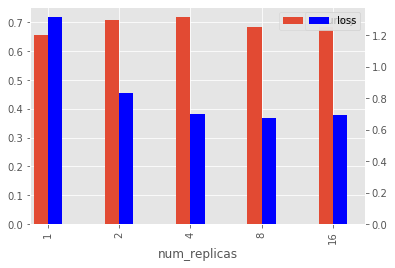

In [215]:
# ax = slstr_benchmark.plot(kind='bar', x='num_replicas', y=['accuracy', 'loss'], ylim=[.75, .9])

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width=0.2
dms_classifier_benchmark.plot(kind='bar', x='num_replicas', y='accuracy', ax=ax, width=width, position=1)
dms_classifier_benchmark.plot(kind='bar', x='num_replicas', y='loss', color='blue', ax=ax2, width=width, position=0)
ax2.grid(None)